refer to the code：https://www.kaggle.com/code/yuanzhezhou/ai4code-distilbert-inference-777

need to excecute the code from top to bottom.

In [31]:
import json
from pathlib import Path

import numpy as np
import pandas as pd
from scipy import sparse
from tqdm import tqdm

from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import mean_squared_error
from bisect import bisect

from transformers import AutoConfig
from transformers import AutoTokenizer, AutoModel
from transformers import DistilBertModel, DistilBertTokenizer
from transformers import RobertaTokenizer

import copy
import sys, os

import torch.nn.functional as F
import torch.nn as nn
import torch
from torch.utils.data import DataLoader, Dataset

import time

import matplotlib.pyplot as plt


In [32]:
pd.options.display.width = 180
pd.options.display.max_colwidth = 120

bert = AutoModel.from_pretrained("microsoft/codebert-base")
data_dir = Path('../input/ai4code')

In [33]:
#Read dataset
def read_notebook(path):
    return (
        pd.read_json(
            path,
            dtype={'cell_type': 'category', 'source': 'str'})
        .assign(id=path.stem)
        .rename_axis('cell_id'))

In [34]:
#Get the kendall tau corelation values
def count_inversions(a):
    inversions = 0
    sorted_so_far = []
    for i, u in enumerate(a):
        j = bisect(sorted_so_far, u)
        inversions += i - j
        sorted_so_far.insert(j, u)
    return inversions


def kendall_tau(ground_truth, predictions):
    total_inversions = 0
    total_2max = 0  # twice the maximum possible inversions across all instances
    for gt, pred in zip(ground_truth, predictions):
        ranks = [gt.index(x) for x in pred]  # rank predicted order in terms of ground truth
        total_inversions += count_inversions(ranks)
        n = len(gt)
        total_2max += n * (n - 1)
    return 1 - 4 * total_inversions / total_2max

In [35]:
#Get the different intermediate blocks
def deletelayers(model, num_layers_to_keep,n):
    oldModuleList = model.encoder.layer
    newModuleList = nn.ModuleList()
    
    for j in range(0, num_layers_to_keep):
        newModuleList.append(oldModuleList[j])
        
    for i in range(num_layers_to_keep,11):
        newModuleList.append(oldModuleList[i].attention)
        
    copyofModel = copy.deepcopy(model)
    copyofModel.encoder.layer = newModuleList
    
    return copyofModel

In [36]:
#Get the different self-attention blocks
def deletelayers_attention(model, num_layers_to_keep,n):
    oldModuleList = model.encoder.layer
    newModuleList = nn.ModuleList()
    
    for j in range(0, num_layers_to_keep):
        newModuleList.append(oldModuleList[j])
        
    for i in range(num_layers_to_keep, n):
        newModuleList.append(oldModuleList[i].attention.output)
        newModuleList.append(oldModuleList[i].intermediate)
        newModuleList.append(oldModuleList[i].output)
            
        
    copyofModel = copy.deepcopy(model)
    copyofModel.encoder.layer = newModuleList
    
    return copyofModel

In [37]:
#Get the different encoder layers
def deletelayers_layer(model, num_layers_to_keep,n):
    oldModuleList = model.encoder.layer
    newModuleList = nn.ModuleList()
    
    for j in range(0, num_layers_to_keep):
        newModuleList.append(oldModuleList[j])
        
    copyofModel = copy.deepcopy(model)
    copyofModel.encoder.layer = newModuleList
    
    return copyofModel

In [38]:
#Get the different combination of intermediate blocks and encoder layers
def deletelayers_layer_attention(model, num_layers_to_keep,n):
    oldModuleList = model.encoder.layer
    newModuleList = nn.ModuleList()
    
    for j in range(0, num_layers_to_keep):
        newModuleList.append(oldModuleList[j])
        
    for i in range(num_layers_to_keep,n):
        newModuleList.append(oldModuleList[i].attention)
        
    copyofModel = copy.deepcopy(model)
    copyofModel.encoder.layer = newModuleList
    
    return copyofModel

In [39]:
#Build a model
class MarkdownModel(nn.Module):
    def __init__(self,deletemodel,num_intermediate_to_keep, num_layer):
        super(MarkdownModel, self).__init__()
        #self.distill_bert = DistilBertModel.from_pretrained('../input/huggingface-bert-variants/distilbert-base-uncased/distilbert-base-uncased')
        self.num_intermediate_to_keep = num_intermediate_to_keep 
        self.num_layer = num_layer
        self.deletemodel = deletemodel
        self.distill_bert = self.deletemodel(bert, self.num_intermediate_to_keep, self.num_layer)
        self.top1 = nn.Linear(768, 64)
        self.top2 = nn.Linear(64, 1)

        self.dropout1 = torch.nn.Dropout(p=0.2)
        self.dropout2 = torch.nn.Dropout(p=0.2)
        
    def forward(self, ids, mask):
        #print(ids.shape)
        x = self.distill_bert(ids, mask)[0][:, 0, :]
        x = self.dropout1(x)
        x0 = self.top1(x)
        x = self.dropout2(x0)
        x = self.top2(x)
        x = torch.sigmoid(x)
        return x

In [40]:
#Build a model
class MarkdownModel_attention(nn.Module):
    def __init__(self,deletemodel,num_intermediate_to_keep, num_layer):
        super(MarkdownModel, self).__init__()
        self.distill_bert = AutoModel.from_pretrained("microsoft/codebert-base", config=my_config)
        self.top1 = nn.Linear(768, 64)
        self.top2 = nn.Linear(64, 1)

        self.dropout1 = torch.nn.Dropout(p=0.2)
        self.dropout2 = torch.nn.Dropout(p=0.2)
        
    def forward(self, ids, mask):
        #print(self.distill_bert(ids, mask)[0][:, 0, :])
        x = self.distill_bert(ids, mask)[0][:, 0, :]
        x = self.dropout1(x)
        x0 = self.top1(x)
        x = self.dropout2(x0)
        x = self.top2(x)
        x = torch.sigmoid(x)
        return x

In [41]:
#Customize a dataset
class MarkdownDataset(Dataset):
    
    def __init__(self, df, max_len):
        super().__init__()
        self.df = df.reset_index(drop=True)
        self.max_len = max_len
        #self.tokenizer = DistilBertTokenizer.from_pretrained('../input/huggingface-bert-variants/distilbert-base-uncased/distilbert-base-uncased', do_lower_case=True)
        self.tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base", do_lower_case=False)

    def __getitem__(self, index):
        row = self.df.iloc[index]
        
        inputs = self.tokenizer.encode_plus(
            row.source,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",
            return_token_type_ids=True,
            truncation=True
        )
        ids = torch.LongTensor(inputs['input_ids'])
        mask = torch.LongTensor(inputs['attention_mask'])

        return ids, mask, torch.FloatTensor([row.pct_rank])

    def __len__(self):
        return self.df.shape[0]
    

In [42]:
#Get the best learning rate
def adjust_lr(optimizer, epoch):
    if epoch < 1:
        lr = 5e-5
    elif epoch < 2:
        lr = 1e-3
    elif epoch < 5:
        lr = 1e-4
    else:
        lr = 1e-5

    for p in optimizer.param_groups:
        p['lr'] = lr
    return lr
    
def get_optimizer(net):
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=3e-4, betas=(0.9, 0.999),
                                 eps=1e-08)
    return optimizer


In [43]:
#Train and test data
def read_data(data):
    return tuple(d.cuda() for d in data[:-1]), data[-1].cuda()


def validate(model, val_loader):
    model.eval()
    
    tbar = tqdm(val_loader, file=sys.stdout)
    
    preds = []
    labels = []

    with torch.no_grad():
        for idx, data in enumerate(tbar):
            inputs, target = read_data(data)
            #print(inputs, target)

            pred = model(inputs[0], inputs[1])

            preds.append(pred.detach().cpu().numpy().ravel())
            labels.append(target.detach().cpu().numpy().ravel())
    
    return np.concatenate(labels), np.concatenate(preds)

def train(model, train_loader, val_loader, epochs):
    np.random.seed(0)
    
    optimizer = get_optimizer(model)

    criterion = torch.nn.MSELoss()
    
    for e in range(epochs):
        start = 0
        start = time.time()
        model.train()
        tbar = tqdm(train_loader, file=sys.stdout)
        
        lr = adjust_lr(optimizer, e)
        
        loss_list = []
        preds = []
        labels = []

        for idx, data in enumerate(tbar):
            inputs, target = read_data(data)
            print(inputs[1].shape)

            optimizer.zero_grad()
            pred = model(inputs[0], inputs[1])

            loss = criterion(pred, target)
            loss.backward()
            optimizer.step()
            
            loss_list.append(loss.detach().cpu().item())
            preds.append(pred.detach().cpu().numpy().ravel())
            labels.append(target.detach().cpu().numpy().ravel())
            
            avg_loss = np.round(np.mean(loss_list), 4)

            tbar.set_description(f"Epoch {e+1} Loss: {avg_loss} lr: {lr}")
        
        y_train, y_pred_train = validate(model, train_loader)
        y_val, y_pred = validate(model, val_loader)
        
        end = 0
        end = time.time()
        print("Training MSE:", np.round(mean_squared_error(y_train, y_pred_train), 4))    
        print("Validation MSE:", np.round(mean_squared_error(y_val, y_pred), 4))
        print('Running time:', end - start)
        print()
    return model, y_pred, np.round(mean_squared_error(y_train, y_pred_train), 4), np.round(mean_squared_error(y_val, y_pred), 4),end - start

In [44]:
#Get the training data

NUM_TRAIN = 1000

paths_train = list((data_dir / 'train').glob('*.json'))[:NUM_TRAIN]
notebooks_train = [
    read_notebook(path) for path in tqdm(paths_train, desc='Train NBs')
]
df = (
    pd.concat(notebooks_train)
    .set_index('id', append=True)
    .swaplevel()
    .sort_index(level='id', sort_remaining=False)
)


Train NBs: 100%|██████████| 1000/1000 [00:05<00:00, 194.03it/s]


In [45]:
#Combine all of csv into one table
df_orders = pd.read_csv(
    data_dir / 'train_orders.csv',
    index_col='id',
    squeeze=True,
).str.split()  # Split the string representation of cell_ids into a list

def get_ranks(base, derived):
    return [base.index(d) for d in derived]

#nb

df_orders_ = df_orders.to_frame().join(
    df.reset_index('cell_id').groupby('id')['cell_id'].apply(list),
    how='right',
)

ranks = {}
for id_, cell_order, cell_id in df_orders_.itertuples():
    ranks[id_] = {'cell_id': cell_id, 'rank': get_ranks(cell_order, cell_id)}

df_ranks = (
    pd.DataFrame
    .from_dict(ranks, orient='index')
    .rename_axis('id')
    .apply(pd.Series.explode)
    .set_index('cell_id', append=True)
)

#df_ranks

df_ancestors = pd.read_csv(data_dir / 'train_ancestors.csv', index_col='id')
#df_ancestors

df = df.reset_index().merge(df_ranks, on=["id", "cell_id"]).merge(df_ancestors, on=["id"])

In [46]:
#Normalize the rangking for each snippet of code
df["pct_rank"] = df["rank"] / df.groupby("id")["cell_id"].transform("count")

In [47]:
#Split the data into 2 sets
NVALID = 1/3 

splitter = GroupShuffleSplit(n_splits=1, test_size=NVALID, random_state=0)

train_ind, val_ind = next(splitter.split(df, groups=df["ancestor_id"]))

train_df = df.loc[train_ind].reset_index(drop=True)
val_df = df.loc[val_ind].reset_index(drop=True)

In [48]:
#Get the markdown data
train_df_mark = train_df[train_df["cell_type"] == "markdown"].reset_index(drop=True)
val_df_mark = val_df[val_df["cell_type"] == "markdown"].reset_index(drop=True)

In [49]:
#Get dataloader
MAX_LEN = 128

train_ds = MarkdownDataset(train_df_mark, max_len=MAX_LEN)
val_ds = MarkdownDataset(val_df_mark, max_len=MAX_LEN)


BS = 32
NW = 2

train_loader = DataLoader(train_ds, batch_size=BS, shuffle=True, num_workers=NW,
                          pin_memory=False, drop_last=True)
val_loader = DataLoader(val_ds, batch_size=BS, shuffle=False, num_workers=NW,
                          pin_memory=False, drop_last=False)

### Get figure 5.2 in dissertation

In [50]:
#get Kendall Tau Correlation values for 0-1 intermediate blocks and 1 layers 
train_error_n = []
vali_error_n = []
kt_error_n = []
time_list_n = []
kt_layers = []

for num_layers_to_keep in range(2):
    
    model = MarkdownModel(deletelayers_layer_attention, num_layers_to_keep, 1)
    model = model.cuda()
    model, y_pred, train_MSE, vali_MSE, time_n = train(model, train_loader, val_loader, epochs=1)
    train_error_n.append(train_MSE)
    vali_error_n.append(vali_MSE)
    time_list_n.append(time_n)
    torch.save(model, 'codebert-trained2.pkl')
    val_df["pred"] = val_df.groupby(["id", "cell_type"])["rank"].rank(pct=True)
    val_df.loc[val_df["cell_type"] == "markdown", "pred"] = y_pred
    y_dummy = val_df.sort_values("pred").groupby('id')['cell_id'].apply(list)
    kt_error_n.append(kendall_tau(df_orders.loc[y_dummy.index], y_dummy))
    
print(kt_error_n)

100%|██████████| 152/152 [00:05<00:00, 27.66it/s]
Training MSE: 0.0702
Validation MSE: 0.0757
Running time: 37.170520305633545

100%|██████████| 152/152 [00:05<00:00, 27.89it/s]
Training MSE: 0.0637
Validation MSE: 0.0718
Running time: 41.448891162872314

[0.6687024437376705, 0.6822818954064174]


In [51]:
#get Kendall Tau Correlation values for 0-2 intermediate blocks and 2 layers  
train_error_n = []
vali_error_n = []
kt_error_n = []
time_list_n = []
kt_layers = []

for num_layers_to_keep in range(3):
    model = MarkdownModel(deletelayers_layer_attention, num_layers_to_keep, 2)
    model = model.cuda()
    model, y_pred, train_MSE, vali_MSE, time_n = train(model, train_loader, val_loader, epochs=1)
    train_error_n.append(train_MSE)
    vali_error_n.append(vali_MSE)
    time_list_n.append(time_n)
    torch.save(model, 'codebert-trained2.pkl')
    val_df["pred"] = val_df.groupby(["id", "cell_type"])["rank"].rank(pct=True)
    val_df.loc[val_df["cell_type"] == "markdown", "pred"] = y_pred
    y_dummy = val_df.sort_values("pred").groupby('id')['cell_id'].apply(list)
    kt_error_n.append(kendall_tau(df_orders.loc[y_dummy.index], y_dummy))
    #kt_layers.append(kt_error_n)
print(kt_error_n)

 73%|███████▎  | 111/152 [00:03<00:01, 29.94it/s]


KeyboardInterrupt: 

In [52]:
#get Kendall Tau Correlation values for 0-3 intermediate blocks and 3 layers 
train_error_n = []
vali_error_n = []
kt_error_n = []
time_list_n = []
kt_layers = []

for num_layers_to_keep in range(4):
    model = MarkdownModel(deletelayers_layer_attention, num_layers_to_keep, 3)
    model = model.cuda()
    model, y_pred, train_MSE, vali_MSE, time_n = train(model, train_loader, val_loader, epochs=1)
    train_error_n.append(train_MSE)
    vali_error_n.append(vali_MSE)
    time_list_n.append(time_n)
    torch.save(model, 'codebert-trained2.pkl')
    val_df["pred"] = val_df.groupby(["id", "cell_type"])["rank"].rank(pct=True)
    val_df.loc[val_df["cell_type"] == "markdown", "pred"] = y_pred
    y_dummy = val_df.sort_values("pred").groupby('id')['cell_id'].apply(list)
    kt_error_n.append(kendall_tau(df_orders.loc[y_dummy.index], y_dummy))
    #kt_layers.append(kt_error_n)
print(kt_error_n)

Epoch 1 Loss: 0.0782 lr: 5e-05:  16%|█▌        | 55/342 [00:03<00:20, 13.82it/s]


KeyboardInterrupt: 

In [53]:
#get Kendall Tau Correlation values for 0-4 intermediate blocks and 4 layers 
train_error_n = []
vali_error_n = []
kt_error_n = []
time_list_n = []
kt_layers = []

for num_layers_to_keep in range(5):
    model = MarkdownModel(deletelayers_layer_attention, num_layers_to_keep, 4)
    model = model.cuda()
    model, y_pred, train_MSE, vali_MSE, time_n = train(model, train_loader, val_loader, epochs=1)
    train_error_n.append(train_MSE)
    vali_error_n.append(vali_MSE)
    time_list_n.append(time_n)
    torch.save(model, 'codebert-trained2.pkl')
    val_df["pred"] = val_df.groupby(["id", "cell_type"])["rank"].rank(pct=True)
    val_df.loc[val_df["cell_type"] == "markdown", "pred"] = y_pred
    y_dummy = val_df.sort_values("pred").groupby('id')['cell_id'].apply(list)
    kt_error_n.append(kendall_tau(df_orders.loc[y_dummy.index], y_dummy))
    #kt_layers.append(kt_error_n)
print(kt_error_n)

Epoch 1 Loss: 0.0695 lr: 5e-05:  21%|██        | 72/342 [00:05<00:21, 12.83it/s]


KeyboardInterrupt: 

In [54]:
#get Kendall Tau Correlation values for 0-5 intermediate blocks and 5 layers 
train_error_n = []
vali_error_n = []
kt_error_n = []
time_list_n = []
kt_layers = []

for num_layers_to_keep in range(6):
    model = MarkdownModel(deletelayers_layer_attention, num_layers_to_keep, 5)
    model = model.cuda()
    model, y_pred, train_MSE, vali_MSE, time_n = train(model, train_loader, val_loader, epochs=1)
    train_error_n.append(train_MSE)
    vali_error_n.append(vali_MSE)
    time_list_n.append(time_n)
    torch.save(model, 'codebert-trained2.pkl')
    val_df["pred"] = val_df.groupby(["id", "cell_type"])["rank"].rank(pct=True)
    val_df.loc[val_df["cell_type"] == "markdown", "pred"] = y_pred
    y_dummy = val_df.sort_values("pred").groupby('id')['cell_id'].apply(list)
    kt_error_n.append(kendall_tau(df_orders.loc[y_dummy.index], y_dummy))
    #kt_layers.append(kt_error_n)
print(kt_error_n)

Epoch 1 Loss: 0.0739 lr: 5e-05:  14%|█▍        | 48/342 [00:05<00:33,  8.79it/s]


KeyboardInterrupt: 

In [55]:
#get Kendall Tau Correlation values for 0-6 intermediate blocks and 6 layers  
train_error_n = []
vali_error_n = []
kt_error_n = []
time_list_n = []
kt_layers = []

for num_layers_to_keep in range(7):
    model = MarkdownModel(deletelayers_layer_attention, num_layers_to_keep, 6)
    model = model.cuda()
    model, y_pred, train_MSE, vali_MSE, time_n = train(model, train_loader, val_loader, epochs=1)
    train_error_n.append(train_MSE)
    vali_error_n.append(vali_MSE)
    time_list_n.append(time_n)
    torch.save(model, 'codebert-trained2.pkl')
    val_df["pred"] = val_df.groupby(["id", "cell_type"])["rank"].rank(pct=True)
    val_df.loc[val_df["cell_type"] == "markdown", "pred"] = y_pred
    y_dummy = val_df.sort_values("pred").groupby('id')['cell_id'].apply(list)
    kt_error_n.append(kendall_tau(df_orders.loc[y_dummy.index], y_dummy))
    #kt_layers.append(kt_error_n)
print(kt_error_n)

Epoch 1 Loss: 0.0744 lr: 5e-05:  13%|█▎        | 43/342 [00:04<00:29, 10.00it/s]


KeyboardInterrupt: 

In [56]:
#get Kendall Tau Correlation values for 0-7 intermediate blocks and 7 layers 
train_error_n = []
vali_error_n = []
kt_error_n = []
time_list_n = []
kt_layers = []

for num_layers_to_keep in range(8):
    model = MarkdownModel(deletelayers_layer_attention, num_layers_to_keep, 7)
    model = model.cuda()
    model, y_pred, train_MSE, vali_MSE, time_n = train(model, train_loader, val_loader, epochs=1)
    train_error_n.append(train_MSE)
    vali_error_n.append(vali_MSE)
    time_list_n.append(time_n)
    torch.save(model, 'codebert-trained2.pkl')
    val_df["pred"] = val_df.groupby(["id", "cell_type"])["rank"].rank(pct=True)
    val_df.loc[val_df["cell_type"] == "markdown", "pred"] = y_pred
    y_dummy = val_df.sort_values("pred").groupby('id')['cell_id'].apply(list)
    kt_error_n.append(kendall_tau(df_orders.loc[y_dummy.index], y_dummy))
    #kt_layers.append(kt_error_n)
print(kt_error_n)

Epoch 1 Loss: 0.0759 lr: 5e-05:   8%|▊         | 27/342 [00:04<00:57,  5.49it/s]


KeyboardInterrupt: 

In [57]:
#get Kendall Tau Correlation values for 0-8 intermediate blocks and 8 layers 
train_error_n = []
vali_error_n = []
kt_error_n = []
time_list_n = []
kt_layers = []

for num_layers_to_keep in range(9):
    model = MarkdownModel(deletelayers_layer_attention, num_layers_to_keep, 8)
    model = model.cuda()
    model, y_pred, train_MSE, vali_MSE, time_n = train(model, train_loader, val_loader, epochs=1)
    train_error_n.append(train_MSE)
    vali_error_n.append(vali_MSE)
    time_list_n.append(time_n)
    torch.save(model, 'codebert-trained2.pkl')
    val_df["pred"] = val_df.groupby(["id", "cell_type"])["rank"].rank(pct=True)
    val_df.loc[val_df["cell_type"] == "markdown", "pred"] = y_pred
    y_dummy = val_df.sort_values("pred").groupby('id')['cell_id'].apply(list)
    kt_error_n.append(kendall_tau(df_orders.loc[y_dummy.index], y_dummy))
    #kt_layers.append(kt_error_n)
print(kt_error_n)

Epoch 1 Loss: 0.0721 lr: 5e-05:   8%|▊         | 26/342 [00:03<00:40,  7.87it/s]


KeyboardInterrupt: 

In [58]:
#get Kendall Tau Correlation values for 0-9 intermediate blocks and 9 layers  
train_error_n = []
vali_error_n = []
kt_error_n = []
time_list_n = []
kt_layers = []

for num_layers_to_keep in range(10):
    model = MarkdownModel(deletelayers_layer_attention, num_layers_to_keep, 9)
    model = model.cuda()
    model, y_pred, train_MSE, vali_MSE, time_n = train(model, train_loader, val_loader, epochs=1)
    train_error_n.append(train_MSE)
    vali_error_n.append(vali_MSE)
    time_list_n.append(time_n)
    torch.save(model, 'codebert-trained2.pkl')
    val_df["pred"] = val_df.groupby(["id", "cell_type"])["rank"].rank(pct=True)
    val_df.loc[val_df["cell_type"] == "markdown", "pred"] = y_pred
    y_dummy = val_df.sort_values("pred").groupby('id')['cell_id'].apply(list)
    kt_error_n.append(kendall_tau(df_orders.loc[y_dummy.index], y_dummy))
    #kt_layers.append(kt_error_n)
print(kt_error_n)

Epoch 1 Loss: 0.0734 lr: 5e-05:   6%|▌         | 20/342 [00:04<01:11,  4.52it/s]


KeyboardInterrupt: 

In [59]:
#get Kendall Tau Correlation values for 0-10 intermediate blocks and 10 layers 
train_error_n = []
vali_error_n = []
kt_error_n = []
time_list_n = []
kt_layers = []

for num_layers_to_keep in range(11):
    model = MarkdownModel(deletelayers_layer_attention, num_layers_to_keep, 10)
    model = model.cuda()
    model, y_pred, train_MSE, vali_MSE, time_n = train(model, train_loader, val_loader, epochs=1)
    train_error_n.append(train_MSE)
    vali_error_n.append(vali_MSE)
    time_list_n.append(time_n)
    torch.save(model, 'codebert-trained2.pkl')
    val_df["pred"] = val_df.groupby(["id", "cell_type"])["rank"].rank(pct=True)
    val_df.loc[val_df["cell_type"] == "markdown", "pred"] = y_pred
    y_dummy = val_df.sort_values("pred").groupby('id')['cell_id'].apply(list)
    kt_error_n.append(kendall_tau(df_orders.loc[y_dummy.index], y_dummy))
    #kt_layers.append(kt_error_n)
print(kt_error_n)

Epoch 1 Loss: 0.0742 lr: 5e-05:   7%|▋         | 25/342 [00:03<00:48,  6.58it/s]


KeyboardInterrupt: 

In [60]:
#get Kendall Tau Correlation values for 0-11 intermediate blocks and 11 layers 
train_error_n = []
vali_error_n = []
kt_error_n = []
time_list_n = []
kt_layers = []

for num_layers_to_keep in range(12):
    model = MarkdownModel(deletelayers_layer_attention, num_layers_to_keep, 11)
    model = model.cuda()
    model, y_pred, train_MSE, vali_MSE, time_n = train(model, train_loader, val_loader, epochs=1)
    train_error_n.append(train_MSE)
    vali_error_n.append(vali_MSE)
    time_list_n.append(time_n)
    torch.save(model, 'codebert-trained2.pkl')
    val_df["pred"] = val_df.groupby(["id", "cell_type"])["rank"].rank(pct=True)
    val_df.loc[val_df["cell_type"] == "markdown", "pred"] = y_pred
    y_dummy = val_df.sort_values("pred").groupby('id')['cell_id'].apply(list)
    kt_error_n.append(kendall_tau(df_orders.loc[y_dummy.index], y_dummy))
    #kt_layers.append(kt_error_n)
print(kt_error_n)

Epoch 1 Loss: 0.0702 lr: 5e-05:   7%|▋         | 23/342 [00:03<00:54,  5.87it/s]


KeyboardInterrupt: 

In [61]:
#get Kendall Tau Correlation values for 0-12 intermediate blocks and 12 layers 
train_error_n = []
vali_error_n = []
kt_error_n = []
time_list = []
kt_layers = []

for num_layers_to_keep in range(13):
    model = MarkdownModel(deletelayers_layer_attention, num_layers_to_keep, 12)
    model = model.cuda()
    model, y_pred, train_MSE, vali_MSE, time_n = train(model, train_loader, val_loader, epochs=1)
    train_error_n.append(train_MSE)
    vali_error_n.append(vali_MSE)
    time_list.append(time_n)
    torch.save(model, 'codebert-trained2.pkl')
    val_df["pred"] = val_df.groupby(["id", "cell_type"])["rank"].rank(pct=True)
    val_df.loc[val_df["cell_type"] == "markdown", "pred"] = y_pred
    y_dummy = val_df.sort_values("pred").groupby('id')['cell_id'].apply(list)
    kt_error_n.append(kendall_tau(df_orders.loc[y_dummy.index], y_dummy))
    #kt_layers.append(kt_error_n)
print(kt_error_n)
print(time_list)

Epoch 1 Loss: 0.0723 lr: 5e-05:  11%|█         | 38/342 [00:06<00:53,  5.71it/s]


KeyboardInterrupt: 

In [62]:
#Save results for plotting
kt0 = [0.6820363138612666, 0.6939248762027457]
kt1 = [0.6820473188922906, 0.6922259350215387, 0.6976448327227345]
kt2 = [0.6900479085309392, 0.6957365433391038, 0.7005394742139377, 0.7002938926687869]
kt3 = [0.6882963527291037, 0.6979588550263698, 0.6954386247433472, 0.6966745843230404, 0.6985345625830348]
kt4 = [0.6838021119324091, 0.6908571198518458, 0.7000281814887879, 0.6934779983091106, 0.6990780627239421, 0.6986472885381859]
kt5 = [0.6840932847382000, 0.6950642135351665, 0.6995490961793953, 0.7012279077257538, 0.7015137485406016, 0.6985546922178831, 0.6993397479769716]
kt6 = [0.6897781714239704, 0.6989854664036395, 0.7008575224445428, 0.6935866983372921, 0.6949675912878941, 0.6998711703369701, 0.69680743991304, 0.7036998268851403]
kt7 = [0.6967470510084948, 0.7006683038769677, 0.6964612101936472, 0.6993639035387897, 0.7057369459318008, 0.7028503562945367, 0.7002898667418174, 0.6962639397721325, 0.6976287290148557]
kt8 = [0.6893353194573051, 0.6976971697733403, 0.6971496437054632, 0.698365473650308, 0.6942348725794114, 0.697254317806675, 0.7001207778090905, 0.6970731510930392, 0.6988566367406095, 0.6988284552518218]
kt9 = [0.6888964934176094, 0.6945247393212287, 0.7014855670518136, 0.697089254800918, 0.7011876484560571, 0.7001127259551512, 0.6954507025242562, 0.6924755424936592, 0.6986996255887918, 0.6995933813760619, 0.7005153186521196]
kt10 = [0.6890776601312452, 0.6983574217963686, 0.6951608357824389, 0.7021659487096904, 0.7030717822778695, 0.7035589194412013, 0.6989613108418213, 0.6998751962639398, 0.6963283546036475, 0.6961632915978904, 0.7004951890172713, 0.7005394742139377]
kt11 = [0.695184991344257, 0.6964290027778897, 0.6972462659527356, 0.7006280446072708, 0.698288981037884, 0.6986835218809131, 0.6985828737066709, 0.6986150811224284, 0.6977817142397037, 0.7005032408712106, 0.7010507669390877, 0.7007568742703008, 0.7019038672829008]
#kt12 = [0.6954, 0.6779, 0.7006, 0.7079, 0.7063, 0.7050, 0.7077, 0.6888, 0.6973, 0.6946, 0.7012, 0.7002, 0.6955]

Text(4, 0.7057, '[4 0.7057]')

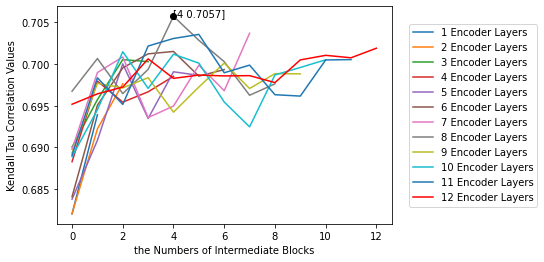

In [63]:
#Plot the chart about the different numbers of intermediate blocks with 8 Encoder Layers vs Kendall Tau Correlation
fig, ax = plt.subplots()
x = np.arange(2,8,1)
ax.plot(kt0, label='1 Encoder Layers')
ax.plot(kt1, label='2 Encoder Layers')
ax.plot(kt2, label='3 Encoder Layers')
ax.plot(kt3, label='4 Encoder Layers')
ax.plot(kt4, label='5 Encoder Layers')
ax.plot(kt5, label='6 Encoder Layers')
ax.plot(kt6, label='7 Encoder Layers')
ax.plot(kt7, label='8 Encoder Layers')
ax.plot(kt8, label='9 Encoder Layers')
ax.plot(kt9, label='10 Encoder Layers')
ax.plot(kt10, label='11 Encoder Layers')
ax.plot(kt11, label='12 Encoder Layers', color='red')
plt.xlabel('the Numbers of Intermediate Blocks')
plt.ylabel('Kendall Tau Correlation Values')
ax.legend(loc='center right', bbox_to_anchor=(1.45, 0.5))
y1_max=np.argmax(kt7)
show_max='['+str(y1_max)+' '+str(round(kt7[y1_max],4))+']'
plt.plot(y1_max,kt7[y1_max],'ko') 
plt.annotate(show_max,xy=(y1_max,kt7[y1_max]),xytext=(y1_max,round(kt7[y1_max],4)))

### Get the table 5.1 in dissertation

In [64]:
#Get the size of modified networks
# 1 attention block
print(7087872 - sum([2359296,3072,2359296,768,768,768]))
# 1 intermediate block
print(sum([2359296,3072,2359296,768,768,768]))

2363904
4723968


In [65]:
#Get the parameters of modified networks with different intermediate blocks
size_i = []
for i in range(0, 13):
    print(i, 'intermediate block: ', (7087872 - sum([2359296,3072,2359296,768,768,768])) * 12 + 38999808 +  (sum([2359296,3072,2359296,768,768,768])) * i)
    size_i.append(round(((7087872 - sum([2359296,3072,2359296,768,768,768])) * 12 + 38999808 +  sum([2359296,3072,2359296,768,768,768]) * i) * 0.000001,2))
size_i

0 intermediate block:  67366656
1 intermediate block:  72090624
2 intermediate block:  76814592
3 intermediate block:  81538560
4 intermediate block:  86262528
5 intermediate block:  90986496
6 intermediate block:  95710464
7 intermediate block:  100434432
8 intermediate block:  105158400
9 intermediate block:  109882368
10 intermediate block:  114606336
11 intermediate block:  119330304
12 intermediate block:  124054272


[67.37,
 72.09,
 76.81,
 81.54,
 86.26,
 90.99,
 95.71,
 100.43,
 105.16,
 109.88,
 114.61,
 119.33,
 124.05]

In [66]:
#Get the time decrese for the different numbers of intermediate blocks with 12 encoder layers
t_ans = []
for i in range(13):
    t_ans.append((time_list[12] - time_list[i]) / time_list[12])
t_ans

IndexError: list index out of range

In [67]:
#Get the size decrese for the different numbers of intermediate blocks with 12 encoder layers
si_ans = []
size_i = [67.37,72.09,76.81,81.54,86.26,90.99,95.71,100.43,105.16,109.88,114.61,119.33,124.05]
for i in range(12,-1,-1):
    si_ans.append((size_i[12] - size_i[i]) / size_i[12])
si_ans

[0.0,
 0.038049173720274075,
 0.07609834744054815,
 0.11422813381700929,
 0.15227730753728336,
 0.19040709391374439,
 0.22845626763401858,
 0.26650544135429266,
 0.3046352277307537,
 0.34268440145102774,
 0.3808141878274889,
 0.41886336154776294,
 0.45691253526803705]

### Get figure 5.1 in dissertation

Text(0, 0.5, 'Values')

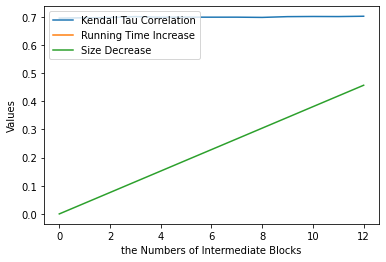

In [68]:
fig, ax = plt.subplots() 
x = np.arange(0,13,1)
ax.plot(kt11, label='Kendall Tau Correlation')
ax.plot(t_ans, label='Running Time Increase')
ax.plot(si_ans, label='Size Decrease')
ax.legend(loc='upper left')
plt.xlabel('the Numbers of Intermediate Blocks')
plt.ylabel('Values')

### Get the table 5.4 in dissertation

In [69]:
##Get errors of the different numbers of encoder layers
train_error_l = []
vali_error_l = []
kt_error_l = []
time_list_l = []
for num_layers_to_keep in range(1,13):
    model = MarkdownModel(deletelayers_layer, num_layers_to_keep,12)
    model = model.cuda()
    model, y_pred, train_MSE, vali_MSE, time_n = train(model, train_loader, val_loader, epochs=1)
    train_error_l.append(train_MSE)
    vali_error_l.append(vali_MSE)
    time_list_l.append(time_n)
    torch.save(model, 'codebert-trained2.pkl')
    val_df["pred"] = val_df.groupby(["id", "cell_type"])["rank"].rank(pct=True)
    val_df.loc[val_df["cell_type"] == "markdown", "pred"] = y_pred
    y_dummy = val_df.sort_values("pred").groupby('id')['cell_id'].apply(list)
    kt_error_l.append(kendall_tau(df_orders.loc[y_dummy.index], y_dummy))
print(kt_error_l)
print(vali_error_l)

100%|██████████| 152/152 [00:05<00:00, 30.22it/s]
Training MSE: 0.0544
Validation MSE: 0.0689
Running time: 40.69127631187439

100%|██████████| 152/152 [00:06<00:00, 24.75it/s]
Training MSE: 0.0511
Validation MSE: 0.0688
Running time: 51.66160750389099

100%|██████████| 152/152 [00:06<00:00, 22.31it/s]
Training MSE: 0.0473
Validation MSE: 0.0691
Running time: 63.1279091835022

100%|██████████| 152/152 [00:07<00:00, 20.81it/s]
Training MSE: 0.0481
Validation MSE: 0.0697
Running time: 77.49831867218018

100%|██████████| 152/152 [00:08<00:00, 17.37it/s]
Training MSE: 0.0449
Validation MSE: 0.0696
Running time: 90.71055722236633

Epoch 1 Loss: 0.0558 lr: 5e-05:  44%|████▎     | 149/342 [00:29<00:38,  4.98it/s]


KeyboardInterrupt: 

### Get the table 5.3 in dissertation

In [ ]:
#Get the time decrease for the different numbers of encoder layers
time_l_d = []
for i in range(13):
    time_l_d.append(round(time_list_l[12]/time_list_l[i],2))
time_l_d

In [ ]:
#Get the parameters of modified networks with different encoder layers
size_l = []
for i in range(0, 13):
    print(i, 'encoder layer: ', round((7087872 * i + 38999808) * 0.000001, 2))
    size_l.append(round((7087872 * i + 38999808) * 0.000001, 2))
size_l

In [ ]:
#Get the size of modified networks with different encoder layers
size_l_d = []
for i in range(13):
    size_l_d.append(round(size_l[12] / size_l[i],2))
size_l_d